# Task 2: Extract a graph from a CTA mask

In [1]:
import os
import numpy as np
import torch
from utils import *
from OstiaDetector import OstiaDetector
from skeleton_to_digraph import *
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.morphology import skeletonize_3d, binary_closing, binary_opening, ball
from scipy.ndimage import label
import warnings
warnings.filterwarnings("ignore")
from skan.csr import Skeleton, summarize, skeleton_to_nx

In [2]:
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device Count: {torch.cuda.device_count()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
CUDA Device Count: 1


## Load the data

In [3]:
# Define the directories containing the files
image_directory = "/data/training_data/"
label_directory = "/data/training_data/"
graph_directory = "/data/training_data/"

# List all the NIfTI files in the directory
image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith('img.nii.gz')]
label_files = [os.path.join(label_directory, f) for f in os.listdir(label_directory) if f.endswith('label.nii.gz')]
graph_files = [os.path.join(graph_directory, f) for f in os.listdir(graph_directory) if f.endswith('graph.json')]

In [4]:
# Create a list of dictionnaries with the data, exclude samples with alleged incorrect number of nodes in their ground-truth graphs
exclude = ["102624", "27badc", "0604cd", "26d228", "04222e", "22cdd3", "29db0c", "0b9189", "1a42d5", "1b3c33", "2f74d6", "108c99", 
           "0cce0b", "064c3e", "234666", "28955b", "0a5b04", "107165", "23c591", "0b06d2","089ee1", "18beb4", "1f594d"]
data = []

for i in image_files:
    if i.split(image_directory)[1][:6] in exclude:
        continue
    for l in label_files:
        for g in graph_files:
            if i.split(image_directory)[1][:6] == l.split(label_directory)[1][:6] == g.split(graph_directory)[1][:6]: # identify the sample
                data += [{'image': i, 'label': l, 'graph': g}]
                break

## Skeletonization and graph initialisation with skimage and skan

In [5]:
sample = data[10]
mask = nib.load(sample['label'])

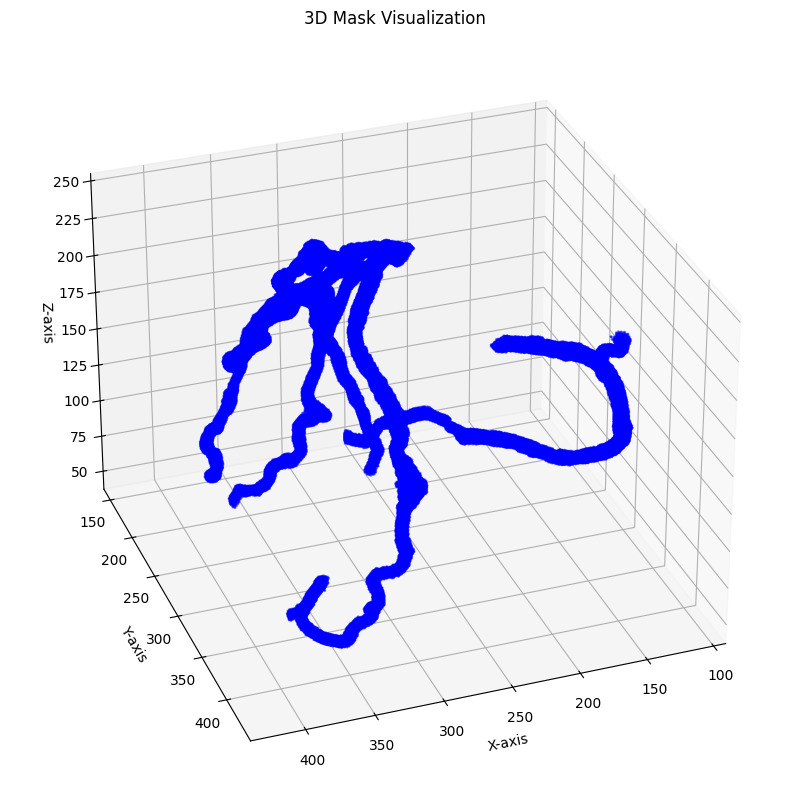

In [6]:
# Plot the mask
mask_array = mask.get_fdata().astype(np.uint8)

# Extract the mask coordinates
mask_coords = np.argwhere(mask_array == 1)
x, y, z = mask_coords[:, 0], mask_coords[:, 1], mask_coords[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the mask points
ax.scatter(x, y, z, c='blue', marker='o', s=1, alpha=0.5)

# Set the axis labels
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("3D Mask Visualization")

ax.azim = 70

plt.show()

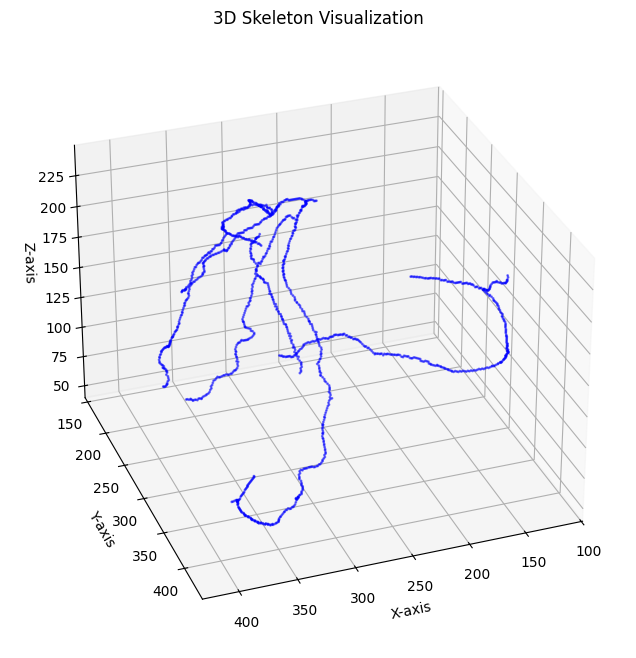

In [7]:
# Plot the skeleton
skeleton = skeletonization(mask)

# Extract the skeleton coordinates
skeleton_coords = np.argwhere(skeleton == 1)
x, y, z = skeleton_coords[:, 0], skeleton_coords[:, 1], skeleton_coords[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the skeleton points
ax.scatter(x, y, z, c='blue', marker='o', s=1, alpha=0.5)

# Set the axis labels
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("3D Skeleton Visualization")

ax.azim = 70

plt.show()

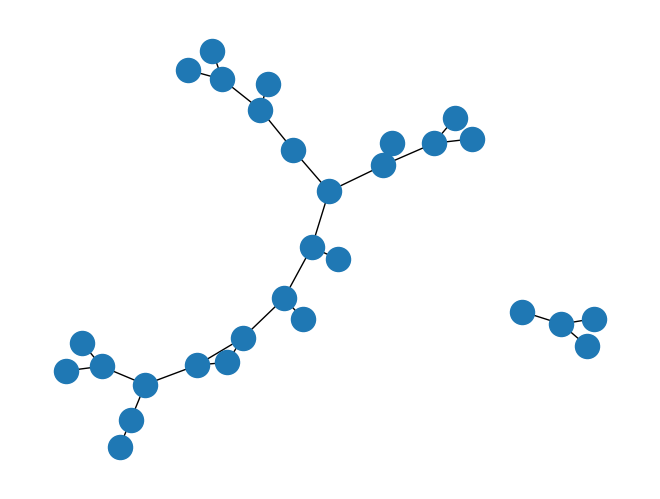

In [8]:
G, summary = graph_initialization(skeleton)
nx.draw(G)

The original mask is not very distinct (especially for the right coronary) and it causes noise in the skeletonization. This translates to the graph here where we get cycles whereas the graph should be two connected trees. In the next part, we make sure that no cycle is left and that the graph has no more than two components.

## Graph processing

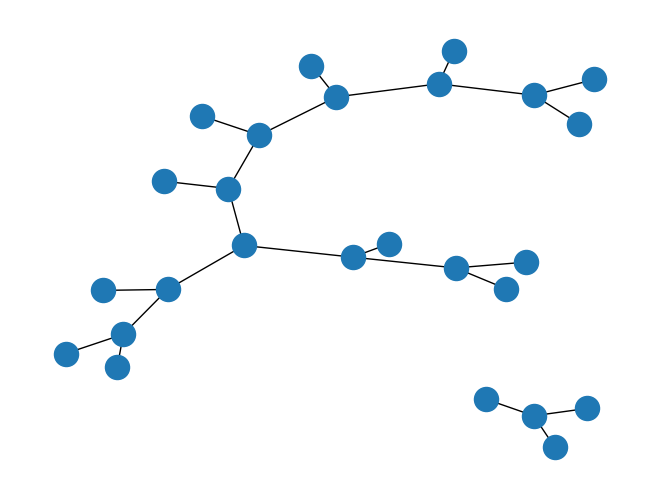

In [9]:
add_node_pos(G, summary, mask)
add_edge_attributes(G, mask)
graph_processing(G)
nx.draw(G)

We finally have two trees without two-degree nodes, that means the structure we were looking for.

## Root nodes detection and directed graph

In [10]:
# Choose a trained model (weights)
model_path = "./ostia_model_trained"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model for root nodes detection
ostia_model = OstiaDetector()
ostia_model.load_state_dict(torch.load(model_path))
ostia_model.eval()

OstiaDetector(
  (conv1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(2, 2, 2))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(4, 4, 4))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (track_conv1): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, t

In [11]:
proximity_map, affine = ostia_proximity_map(sample['image'], ostia_model, device)
root_nodes_identification(G, proximity_map, affine)
DiG = directed_graph(G)

## Graph plotting

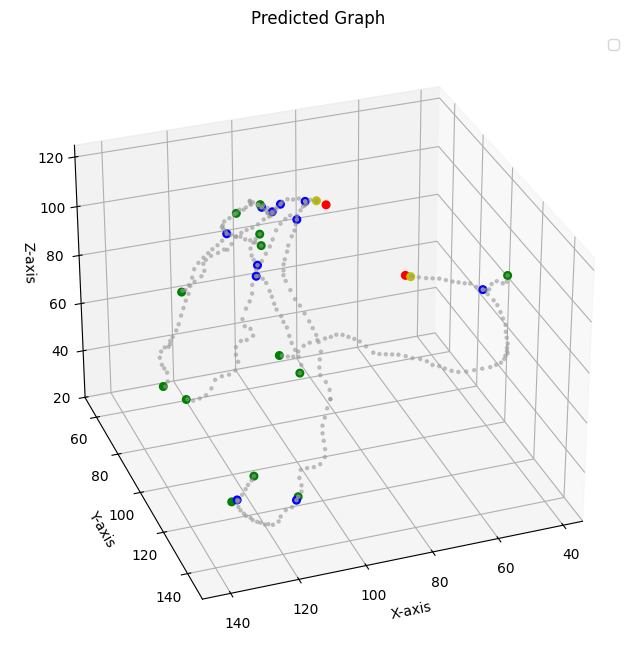

In [12]:
# Plot the predicted graph

# Retrieve all node points in voxel coordinates
node_points = np.array(list(nx.get_node_attributes(DiG, 'pos').values()))

node_points_h = np.hstack((node_points, np.ones((node_points.shape[0], 1))))
node_points_voxel = (node_points_h@np.linalg.inv(affine).T)[:, :3]

# Tag endpoints
is_endpoint = {}

for node in DiG.nodes:
    is_endpoint[node] = True

    if DiG.degree[node] == 3:
        is_endpoint[node] = False

    if DiG.nodes[node]["is_root"]:
        is_endpoint[node] = False

nx.set_node_attributes(DiG, is_endpoint, "is_endpoint")

# Color the root nodes in yellow, the endpoints in green and the bifurcations in blue
is_root = np.array(list(nx.get_node_attributes(DiG, 'is_root').values()))
is_endpoint = np.array(list(nx.get_node_attributes(DiG, 'is_endpoint').values()))

colors = np.where(is_root, "y", "g")
colors[np.where((is_root == False) & (is_endpoint == False))] = "b"

# Retrieve the skeletons in voxel coordinates          
skeletons = []
for start, end in DiG.edges():
    skeletons.extend(DiG[start][end]['skeletons'])
skeletons = np.array(skeletons)

skeletons_h = np.hstack((skeletons, np.ones((skeletons.shape[0], 1))))
skeletons_voxel = (skeletons_h@np.linalg.inv(affine).T)[:, :3]

# Ostia prediction
ostia_pred_voxel = retrieve_ostia_voxel(proximity_map)

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plots
ax.scatter(skeletons_voxel[:, 0], skeletons_voxel[:, 1], skeletons_voxel[:, 2], marker=".", color="#999999", alpha=0.5)
ax.scatter(node_points_voxel[:, 0], node_points_voxel[:, 1], node_points_voxel[:, 2], alpha=1, c=colors, s=30)
ax.scatter(ostia_pred_voxel[:, 0], ostia_pred_voxel[:, 1], ostia_pred_voxel[:, 2], alpha=1, c="r", s=30)

# Set the axis labels
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Predicted Graph")
ax.legend()

ax.azim = 70

plt.show()

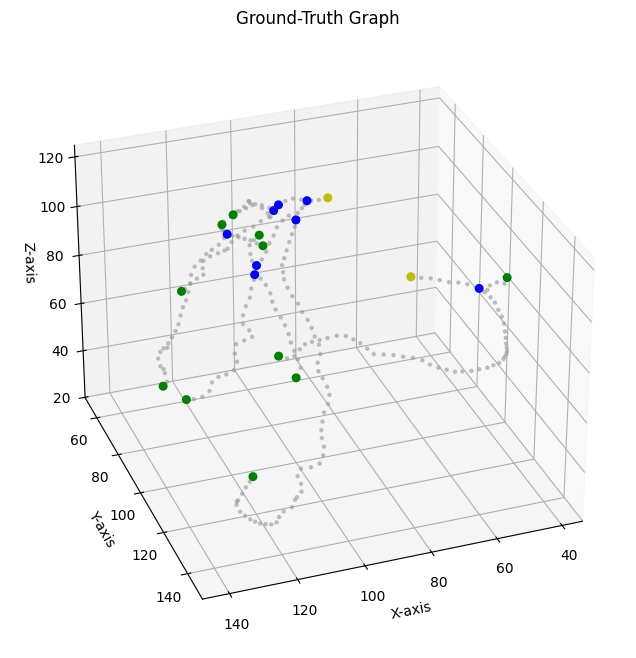

In [13]:
# Plot the ground-truth graph

with open(sample['graph'], "r") as file:
    datag = json.load(file)
graph = json_graph.node_link_graph(datag, edges="edges")

# Retrieve all node points in voxel coordinates
node_points = np.array(list(nx.get_node_attributes(graph, 'pos').values()))

node_points_h = np.hstack((node_points, np.ones((node_points.shape[0], 1))))
node_points_voxel = (node_points_h@np.linalg.inv(affine).T)[:, :3]

# Tag endpoints
is_endpoint = {}

for node in graph.nodes:
    is_endpoint[node] = True

    if graph.degree[node] == 3:
        is_endpoint[node] = False

    if graph.nodes[node]["is_root"]:
        is_endpoint[node] = False

nx.set_node_attributes(graph, is_endpoint, "is_endpoint")

# Color the root nodes in yellow, the endpoints in green and the bifurcations in blue
is_root = np.array(list(nx.get_node_attributes(graph, 'is_root').values()))
is_endpoint = np.array(list(nx.get_node_attributes(graph, 'is_endpoint').values()))

colors = np.where(is_root, "y", "g")
colors[np.where((is_root == False) & (is_endpoint == False))] = "b"

# Retrieve the skeletons in voxel coordinates 
skeletons = []
for start, end in graph.edges():
    skeletons.extend(graph[start][end]['skeletons'])
skeletons = np.array(skeletons)

skeletons_h = np.hstack((skeletons, np.ones((skeletons.shape[0], 1))))
skeletons_voxel = (skeletons_h@np.linalg.inv(affine).T)[:, :3]
          

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plots
ax.scatter(skeletons_voxel[:, 0], skeletons_voxel[:, 1], skeletons_voxel[:, 2], marker=".", color="#999999", alpha=0.5)
ax.scatter(node_points_voxel[:, 0], node_points_voxel[:, 1], node_points_voxel[:, 2], alpha=1, c=colors, s=30)

# Set the axis labels
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Ground-Truth Graph")

ax.azim = 70

plt.show()

In those two graphs, the yellow points are the root nodes, the blue points are the bifurcations and the green points are the endpoints. Besides the predicted graph shows red points that are the predicted locations of the ostia. Those two graphs globally have the same structure but the prediction has some additional nodes. Moreover, the prediction has trouble retrieving all the nodes in parts where different arteries are really close and curvy. This is a limit of the skeletonization.